In [2]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from dirs import PLAYER_DIR, MODEL_DIR, MATCHES_DIR

In [3]:
players_df = pd.read_csv(PLAYER_DIR)
model = load_model(os.path.join(MODEL_DIR, 'model.h5'))
significant_metrics = ['rating', 'average_combat_score', 'kills_per_round', 'headshot_percentage']

In [4]:
top_players = players_df[players_df[significant_metrics].apply(lambda x: x >= x.quantile(0.75)).any(axis=1)]  # takes top 25%
dream_team_stats = top_players[significant_metrics].mean().to_dict()
print("Dream Team Average Stats:", dream_team_stats)

Dream Team Average Stats: {'rating': 1.0524602024612941, 'average_combat_score': 213.63122270742358, 'kills_per_round': 0.7544759825327509, 'headshot_percentage': 0.2953006153235411}


In [5]:
# stats of the other team (pretty bad)
other_team_stats = {
    'rating': 0.75, 
    'average_combat_score': 125.0, 
    'kills_per_round': 0.6, 
    'headshot_percentage': 0.16
}

dream_team_stats_array = np.array([[dream_team_stats[feature] for feature in significant_metrics]])
other_team_stats_array = np.array([[other_team_stats[feature] for feature in significant_metrics]])

In [6]:
dream_team_outcome = model.predict(dream_team_stats_array)
print("Dream Team Win Probability:", dream_team_outcome[0])

# Predict the match outcome for the other team
other_team_outcome = model.predict(other_team_stats_array)
print("Other Team Win Probability:", other_team_outcome[0])

1/1 [==============================] - 0s 325ms/step
Dream Team Win Probability: [0.5052641]
1/1 [==============================] - 0s 29ms/step
Other Team Win Probability: [0.50008005]


Very shocking results -- both teams have a similar win guess percentage

## Check out what really pushes the needle

In [42]:
# same as before to compare later
from scipy.stats import pearsonr

matches_df = pd.read_csv(MATCHES_DIR)

def determine_outcome(row):
    if row['team_name'] == row['team_one_name']:
        return 'win' if row['team_one_score'] > row['team_two_score'] else 'loss'
    else:
        return 'win' if row['team_two_score'] > row['team_one_score'] else 'loss'

merged_one = pd.merge(players_df, matches_df, left_on='team_name', right_on='team_one_name')
merged_two = pd.merge(players_df, matches_df, left_on='team_name', right_on='team_two_name')
full_merged_df = pd.concat([merged_one, merged_two], ignore_index=True)
full_merged_df['match_outcome'] = full_merged_df.apply(determine_outcome, axis=1)

full_merged_df['outcome_binary'] = (full_merged_df['match_outcome'] == 'win').astype(int)
correlation_metrics = [
    'rating', 'average_combat_score', 'kills_per_round', 'assists_per_round', 
    'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage', 
    'clutch_success_percentage', 'outcome_binary'
]

correlation_matrix = full_merged_df[correlation_metrics].corr()

correlation_stats = {}
for metric in correlation_metrics[:-1]:
    corr_coeff, p_value = pearsonr(full_merged_df[metric].dropna(), full_merged_df['outcome_binary'].dropna())
    correlation_stats[metric] = {'Correlation Coefficient': corr_coeff, 'p-value': p_value}
correlation_stats_df = pd.DataFrame(correlation_stats).T
correlation_stats_df

,Correlation Coefficient,p-value
rating,0.230350,0.000018
average_combat_score,0.143565,0.008020
kills_per_round,0.163316,0.002523
assists_per_round,0.075329,0.165794
first_kills_per_round,0.048612,0.371538
first_deaths_per_round,-0.047987,0.377730
headshot_percentage,0.102725,0.058467
clutch_success_percentage,0.078176,0.150325


In [30]:
stats_summary = players_df[significant_metrics].agg(['min', 'max', 'mean']).transpose()
base_input = stats_summary['mean'].values.reshape(1, -1)

In [31]:
def predict_win_probability(updates):
    temp_input = base_input.copy()
    temp_input[0, updates['index']] = updates['value']
    return model.predict(temp_input)[0][0]

1/1 [==============================] - 0s 70ms/step


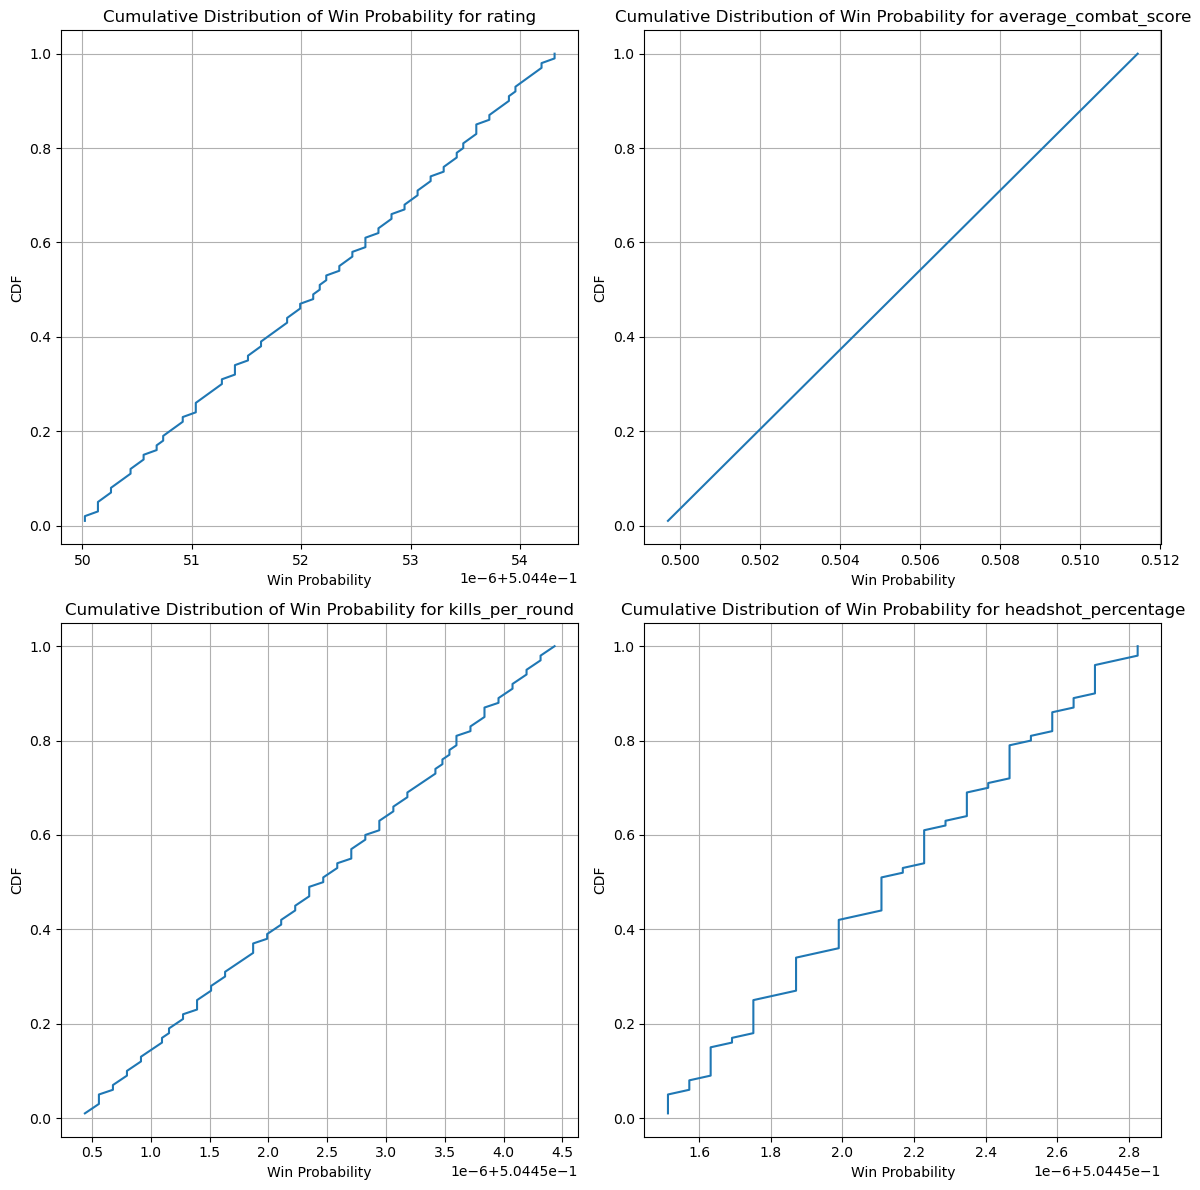

In [47]:
probabilities_cdf = {}
for metric in significant_metrics:
    index = significant_metrics.index(metric)
    min_val = stats_summary.loc[metric, 'min']
    max_val = stats_summary.loc[metric, 'max']
    values = np.linspace(min_val, max_val, 100)
    probabilities_cdf[metric] = [predict_win_probability({'index': index, 'value': v}) for v in values]

# cumulative distribution plots for each sig stat
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, stat in zip(axes, significant_metrics):
    sorted_probs = np.sort(probabilities_cdf[stat])
    cdf = np.arange(1, len(sorted_probs)+1) / len(sorted_probs)
    
    ax.plot(sorted_probs, cdf)
    ax.set_title(f'Cumulative Distribution of Win Probability for {stat}')
    ax.set_xlabel('Win Probability')
    ax.set_ylabel('CDF')
    ax.grid(True)

plt.tight_layout()
plt.show()

## Try again with new information of variable significance

In [8]:
# stats of the other team (pretty bad)
other_team_stats = {
    'rating': 0.5, 
    'average_combat_score': 125.0, 
    'kills_per_round': 0.6, 
    'headshot_percentage': 0.16
}
other_team_stats_array = np.array([[other_team_stats[feature] for feature in significant_metrics]])

dream_team_stats = top_players[significant_metrics].max().to_dict()
dream_team_stats_array = np.array([[dream_team_stats[feature] for feature in significant_metrics]])

print("Dream Team *MAX* Stats:", dream_team_stats)

# Predict the match outcome for the other team
dream_team_outcome = model.predict(dream_team_stats_array)
print("Dream Team Win Probability:", dream_team_outcome[0])
other_team_outcome = model.predict(other_team_stats_array)
print("Other Team Win Probability:", other_team_outcome[0])

Dream Team *MAX* Stats: {'rating': 1.49, 'average_combat_score': 319.4, 'kills_per_round': 1.13, 'headshot_percentage': 0.44}
1/1 [==============================] - 0s 28ms/step
Dream Team Win Probability: [0.51145035]
1/1 [==============================] - 0s 38ms/step
Other Team Win Probability: [0.5000789]


## Conclusion from results:
At the pro level, there are much larger factors than individual performance that seem to lead to victories

- Teamwork
- Coaching
- Strategies
- etc